# Are We Havin' A Laugh?

_The below is a (sanitised) version of a notebook I stuck together for my friends, but thought I'd post it here for future ref. Friends' names have been initialised to provide them some measure of 'anonymity' should they wish to (publicly) distance themselves. Bit of lingo: 'Talf' is our old shared house._

_The notebook lives [here](https://github.com/mjam03/whatsapp/blob/main/notebooks/Are%20We%20Havin'%20A%20Laugh%3F.ipynb) and has been published to here using the very handy library [jupyter_to_medium](https://github.com/dexplo/jupyter_to_medium) for all those who despise admin as much as I do._

-----

Ever since DB voiced his (_or her..._) thoughts on the use of 'haha' and its variants (last year in the kitchen in Talf I think) it's been on my mind that potentially the group has become more generous in doling out their WhatsApp laughter - which is nice. We all like to have a laugh with our mates and what better way than to chuck a 'haha' back on the chat when something tickles you.

Mentioning this recently to DB, he concurred and so I decided to see if this shared feeling pans out in the data. I've [exported](https://faq.whatsapp.com/android/chats/how-to-save-your-chat-history/?lang=en) our diaspora of chats - now let's get stuck in and see if we really are becoming a nicer bunch of guys.

-----

## Step 1: Get The Data, Parse The Data, Tabularise The Data 

First things first, let's parse those .zip files that WhatsApp exports for us and stick them in a 'DataFrame' (I _heart_ pandas) so we can easily analyse the 'banter'. I've wrapped up the functions to parse a WhatsApp convo from a zip in [here](https://github.com/mjam03/whatsapp) to keep things neat and tidy and tidy and neat.

In [20]:
# import libs and suppress pesky warnings
import datetime as dt
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
import string
from zipfile import ZipFile
import warnings

# package up whatsapp parsing files, can be found here https://github.com/mjam03/whatsapp
# instructions are in the read me for how to clone locally and pip install locally
from whatsapp.extract import extract_zip, parse_zip

# set some defaults
sns.set()
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)

In [22]:
?? parse_zip

Signature:  parse_zip(wa_zip)
Docstring: <no docstring>
Source:   
def parse_zip(wa_zip):
    # initialise parsed data as an empty list (to be populated)
    parsed_data = []
    convo_list = wa_zip['_chat.txt'].decode('utf-8').split('\n')

    for line in convo_list:
        line = line.strip()  # remove funny whitespaces
        line = line.replace("\u200e", "")
        if startsWithDateTime(line):  # if starts with date time then we're good to go
            date, time, author, message = getDataPoint(line)
            parsed_data.append([date, time, author, message])

    return parsed_data
File:      ~/dev/whatsapp/whatsapp/extract.py
Type:      function


In [21]:
?? extract_zip

Signature:  extract_zip(input_zip)
Docstring: <no docstring>
Source:   
def extract_zip(input_zip):
    # convert whatsapp zip file to text
    input_zip = ZipFile(input_zip)
    return {name: input_zip.read(name) for name in input_zip.namelist()}
File:      ~/dev/whatsapp/whatsapp/extract.py
Type:      function


Now we've loaded in the heavies, we can use them to parse the convos and form that beautiful table of chatter.

In [3]:
# load in them convos
wa_vow = extract_zip('../data/wa_VOW.zip')
wa_dss = extract_zip('../data/wa_DSS.zip')
wa_rr = extract_zip('../data/wa_RR.zip')
wa_cj = extract_zip('../data/wa_CJ.zip')

# create lists of date / time / author / message per group
vow = parse_zip(wa_vow)
dss = parse_zip(wa_dss)
rr = parse_zip(wa_rr)
cj = parse_zip(wa_cj)

# create dataframes from these
df_vow = pd.DataFrame(vow, columns=['Date', 'Time', 'Author', 'Message'])
df_dss = pd.DataFrame(dss, columns=['Date', 'Time', 'Author', 'Message'])
df_rr = pd.DataFrame(rr, columns=['Date', 'Time', 'Author', 'Message'])
df_cj = pd.DataFrame(cj, columns=['Date', 'Time', 'Author', 'Message'])

# create Group col - maybe hahas vary by group
df_vow['Group'] = 'VOW'
df_dss['Group'] = 'DSS'
df_rr['Group'] = 'RR'
df_cj['Group'] = 'CJ'

# type format each df and drop NaNs
for df in [df_vow, df_dss, df_rr, df_cj]:
    df['Date'] = df['Date'].apply(lambda x: x.replace('[', ''))
    # format them cols
    df['DateTime'] = df['Date'] + ' ' + df['Time']
    df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%Y %H:%M:%S')
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    df.Time = pd.to_datetime(df.Time)
    df.Time = df.Time.apply(lambda x: x.time())
    df['Hour'] = df['Time'].apply(lambda x: x.hour)
    df.dropna(inplace=True)

# bang them together, sort and create month-year col for time-wise grouping
df = pd.concat([df_vow, df_dss, df_rr, df_cj]).sort_values('DateTime')
df['Month'] = df['Date'].dt.strftime('%Y-%m')
df = df[df.Date > '2020-05']

# ~~~anonymise participants~~~
with open('../data/author_map.pickle', 'rb') as handle:
    author_map = pickle.load(handle)
df['Author'] = df['Author'].map(author_map)

# display our BEAUTIFUL tabular data
df.tail(4)

,Date,Time,Author,Message,Group,DateTime,Hour,Month
4906,2021-02-23,08:33:02,DB,same acct you used to pay rent into roop,VOW,2021-02-23 08:33:02,8,2021-02
4907,2021-02-23,08:33:05,DB,many moons ago,VOW,2021-02-23 08:33:05,8,2021-02
4908,2021-02-23,08:33:20,RH,Yer nice,VOW,2021-02-23 08:33:20,8,2021-02
4909,2021-02-23,08:37:29,JB,Don’t embezzle,VOW,2021-02-23 08:37:29,8,2021-02


We now have all our data from May-2020 onwards (when I joined Talf and subsequently them WhatsApp groups) in a nice tabular format (I still *heart* dfs).

------

## Step 2: Visualise Our Nattering

Before specifically looking for any messages that may containing 'lolling', let's just have a look at what our messaging history actually looks like. How much do we chat, who's chatting and why on earth do we maintain 4 different almost identical groups?

### 2a. WhatsApp Activity Quite Correlated With Coronavirus Waves

First let's get an overview of how many messages we've been sending in to our shared groups over the last year.

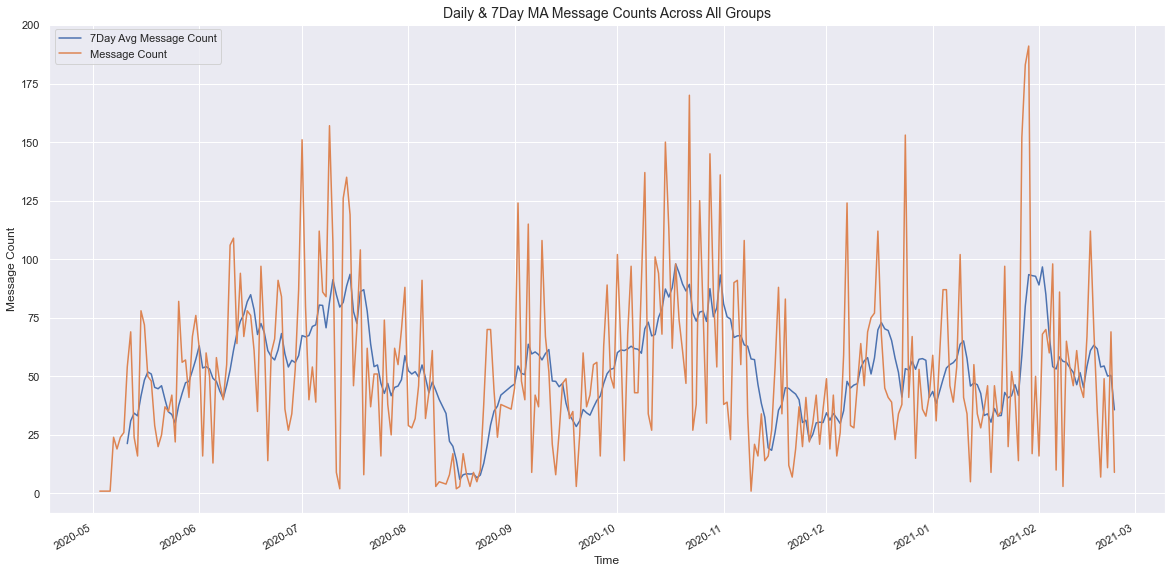

In [4]:
fig, ax = plt.subplots(figsize=(20,10))

df[['Message','Date']].groupby(['Date']).count().rename(columns={'Message': '7Day Avg Message Count'}).rolling(7).mean().plot(ax=ax);
df[['Message','Date']].groupby(['Date']).count().rename(columns={'Message': 'Message Count'}).plot(ax=ax);
ax.set_title('Daily & 7Day MA Message Counts Across All Groups', fontdict={'fontsize': 14})
ax.set_xlabel('Time')
ax.set_ylabel('Message Count');

This one seems like a positive point. It seems like __we like to talk to each other [irl](https://www.urbandictionary.com/define.php?term=irl) more than on WhatsApp__. The big dipper in the middle of August last year is us jollying around Switzerland/Italy and the data reinforces the fact __we're actually quite good mates who like hanging out with each other__.

Activity then picks up again heading into November as restrictions ramp up and we get ourselves through by exchanging __'top quality banter'__ on the chat. It tails off halfway through Nov as the majority of us are in the same room - __again, it seems we prefer to talk to each other irl.__

### 2b. JB is the Glue That Binds Us

Not resting on his laurels, JB (purple) continues to contribute heavily - only being surpassed as the top contributor in 3 months:
 - 2x by EM - which is a stellar effort given he is in only 3 of 4 groups included
 - 1x by MJ - most notably when I was doing some aggressive thumb-twiddling in Belfast last November

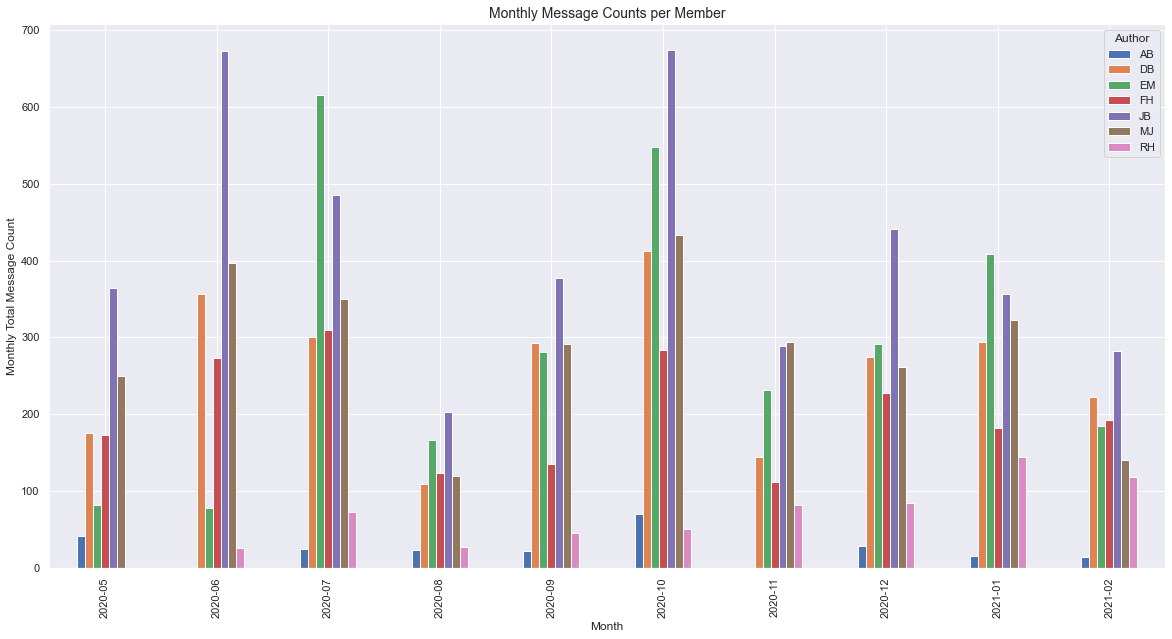

In [5]:
fig, ax = plt.subplots(figsize=(20,10))

pd.pivot_table(df[['Message','Month', 'Author']]
               .groupby(['Month', 'Author']).count(),
               columns='Author',
               index='Month',
               values='Message').plot(kind='bar', ax=ax)
ax.set_title('Monthly Message Counts per Member', fontdict={'fontsize': 14})
ax.set_xlabel('Month')
ax.set_ylabel('Monthly Total Message Count');

### 2c. Long Live the OG Group

Only a recent member, I have no claim on the long history of VOW and its previous incarnations. However, looking at the below (now that Talf is gone and we are sporadically housed) the other groups had their lockdown-induced moments in the sun, __but the OG is back.__

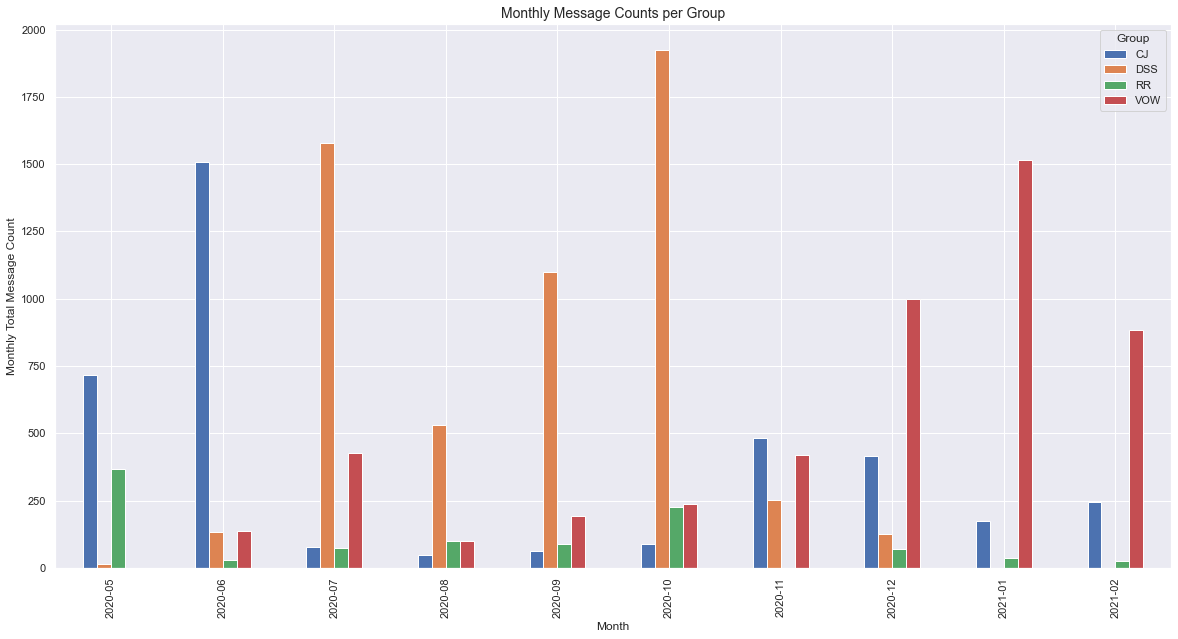

In [6]:
fig, ax = plt.subplots(figsize=(20,10))

pd.pivot_table(df[['Message','Month', 'Group']]
               .groupby(['Month', 'Group']).count(),
               columns='Group',
               index='Month',
               values='Message').plot(kind='bar', ax=ax)
ax.set_title('Monthly Message Counts per Group', fontdict={'fontsize': 14})
ax.set_xlabel('Month')
ax.set_ylabel('Monthly Total Message Count');

Now that we've familiarised ourselves a bit with the *riveting* over-arching properties of our WhatsApp chats, let's get into the core hypothesis - __are we or are we not having a right laugh?__

----

## Step 3: What About Them Haha's? 

Before we can make any statements, we first need to do a bit more work in Python.

### 3a. Defining 'Laughter'

First we need to qualify what text qualifies as a 'laughter response'. To avoid creating a load of jargon, let's reuse jargon developed in 2020 for everyone's least favourite pandemic.

For this, there appear to be 2 main ['variants'](https://trends.google.co.uk/trends/explore?date=all&q=variant):
 - 'haha variant': 'haha', 'hahah', 'hahaha' and even 'aha' and 'ahah'
 - 'lol variant': 'lol', 'lolol', 'llol' etc

We need to construct these word lists then apply a text search function to find messages containing them. Specifically:
 - Need to avoid words where a 'laugh variant' is a substring of a word e.g. 'ha' inside 'happen'
 - Try to minimise the search space; or we will have to search $n$ messages for $m$ substrings which can become very slow

First we define the 'haha variant':

In [7]:
haha_list = []
max_haha_length = 10

# handle the haha variant
for i in range(2, max_haha_length+1):
    # generate combinations
    haha_words = [''.join(x) for x in itertools.product(*(['ha'] * i))]
    # ensure both chars in
    haha_words = [x for x in haha_words if 'h' in x and 'a' in x]
    # remove 'surprise words' like 'ah' and 'ahhh'
    # defined as starting with a's and then not repeating
    for w in haha_words:
        # if starts with 'a'
        if 'a' == w[0]:
            # if following first 'h' there ain't another 'a'
            if 'a' not in w[w.find('h'):]:
                # remove
                haha_words.remove(w)
    
    haha_list.append(haha_words)
    
# flatten that list of lists to a depth=1 list of lol words
haha_list = [item for sublist in haha_list for item in sublist]
# need to reverse the lists to prevent 'haha' being detected as 'ha'
# i.e. long words come first
haha_list.reverse()
print("We now have a list of {:,} possible 'haha' words".format(len(haha_list)))

We now have a list of 1,981 possible 'haha' words


Now the lol variant (being careful to remove things like 'oll' which appear frequently in words:

In [8]:
lol_list = []
max_lol_length = 10
# avoid any other 3 letter iteration of chars 'ol'
# common in words like 'collect', 'holly' etc
lol_list.append(['lol'])

# handle the haha variant
for i in range(4, max_lol_length+1):
    # generate combinations
    lol_words = [''.join(x) for x in itertools.product(*(['lo'] * i))]
    # ensure both chars in
    lol_words = [x for x in lol_words if 'l' in x and 'o' in x]
    lol_list.append(lol_words)
    
# flatten that list of lists to a depth=1 list of lol words
lol_list = [item for sublist in lol_list for item in sublist]
# need to reverse the lists to prevent 'lolol' being detected as 'lol'
lol_list.reverse()
print("We now have a list of {:,} possible 'lol' words".format(len(lol_list)))

We now have a list of 2,019 possible 'lol' words


And define a function to search for these substrings in the message strings, avoiding 'embedded laugh words':

In [9]:
def laugh_finder(mess, laugh_list):
    # only get laugh_list where elements are shorter than message length
    # you can't find 'hahahah' in a message with only 3 chars e.g. 'yes'
    poss_laughs = [x for x in laugh_list if len(x) <= len(mess)]
    mess = mess.lower()
    # now we iterate through and check if string contains word
    for word in poss_laughs:
        if word in mess:
            # if only 2 chars in message after stripping spaces
            # then only ha involved, so true
            if len(set(mess.replace(' ',''))) == 2:
                return [True, word]
            # else we need to remove e.g. 'ha' as part of another word
            # e.g. 'ha'ppen showing up
            mess_list = mess.split(' ')
            key_word = [x for x in mess_list if word in x]
            for kw in key_word:
                if len(set(kw)) == 2:
                    return [True, word]
    # else not found
    return [False, 'None']

We can now apply this function as a lambda function to our table and generate a few columns which we can use to generate the good stuff - pretty charts.

In [10]:
# apply these functions, plus create any laugh col
df[['ContainsHahaWord', 'HahaLaughWord']] = df['Message'].apply(lambda x: laugh_finder(x, haha_list)).to_list()
df[['ContainsLolWord', 'LolLaughWord']] = df['Message'].apply(lambda x: laugh_finder(x, lol_list)).to_list()
df['ContainsLaughWord'] = df[['ContainsHahaWord', 'ContainsLolWord']].any(axis=1)
df['ContainsBothLaughWord'] = df[['ContainsHahaWord', 'ContainsLolWord']].all(axis=1)

# define if only laugh word, or part of a larger message
df['OnlyHahaWord'] = (df['ContainsHahaWord'] & (df['Message'].str.split(' ').str.len() < 2))
df['OnlyLolWord'] = (df['ContainsLolWord'] & (df['Message'].str.split(' ').str.len() < 2))
df['OnlyLaughWord'] = (df['ContainsLaughWord'] & (df['Message'].str.split(' ').str.len() < 2))

# spit out the 'laugh word' we have found for analysis
df['LaughWord'] = np.where(df['HahaLaughWord'] != 'None', df['HahaLaughWord'], df['LolLaughWord'])
df.tail(4)

,Date,Time,Author,Message,Group,DateTime,Hour,Month,ContainsHahaWord,HahaLaughWord,ContainsLolWord,LolLaughWord,ContainsLaughWord,ContainsBothLaughWord,OnlyHahaWord,OnlyLolWord,OnlyLaughWord,LaughWord
4906,2021-02-23,08:33:02,DB,same acct you used to pay rent into roop,VOW,2021-02-23 08:33:02,8,2021-02,False,None,False,None,False,False,False,False,False,None
4907,2021-02-23,08:33:05,DB,many moons ago,VOW,2021-02-23 08:33:05,8,2021-02,False,None,False,None,False,False,False,False,False,None
4908,2021-02-23,08:33:20,RH,Yer nice,VOW,2021-02-23 08:33:20,8,2021-02,False,None,False,None,False,False,False,False,False,None
4909,2021-02-23,08:37:29,JB,Don’t embezzle,VOW,2021-02-23 08:37:29,8,2021-02,False,None,False,None,False,False,False,False,False,None


We now have our data ready to analyse (!!!).

### 3b. Laughter Matrices

So which words do we use the most to express a tittle? And does this change depending on whether or not the message has accompanying text?

#### 3bi. Messages only containing a 'laugh word' - no additional text

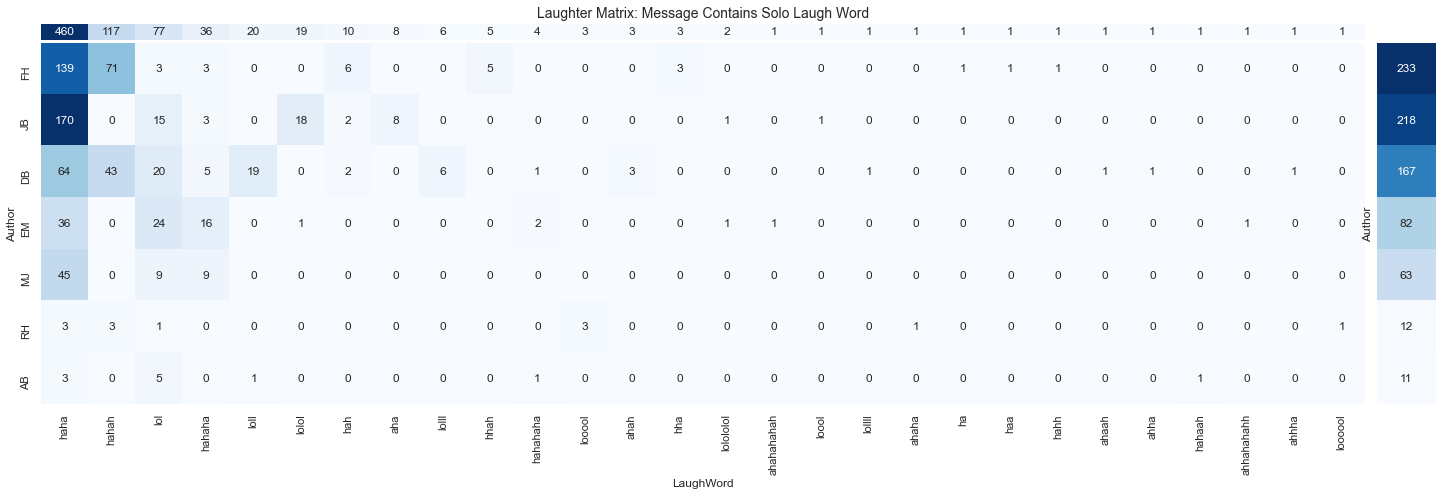

In [11]:
# amended/stripped from https://stackoverflow.com/questions/33379261/how-can-i-have-a-bar-next-to-python-seaborn-heatmap-which-shows-the-summation-of
# create heatmap with totals
fig = plt.figure(figsize=(25,7))
ax2 = plt.subplot2grid((20,20), (0,0), colspan=19, rowspan=1)
ax1 = plt.subplot2grid((20,20), (1,0), colspan=19, rowspan=19)
ax3 = plt.subplot2grid((20,20), (1,19), colspan=1, rowspan=19)

# create grid with rows and cols sorted (condenses colour in top left)
df_lm = pd.pivot_table(df[df.OnlyLaughWord][['Author', 'LaughWord', 'Message']]
                       .groupby(['Author', 'LaughWord']).count(),
                       columns='LaughWord',
                       index='Author',
                       values='Message').fillna(0)
df_lm = df_lm.loc[df_lm.sum(axis=1).sort_values(ascending=False).index][df_lm.sum().sort_values(ascending=False).index]

# plot the heatmap
sns.heatmap(df_lm,
            ax=ax1,
            cmap='Blues',
            annot=True,
            cbar=False,
            fmt=',.0f');
# plot the row totals on the far right
sns.heatmap(pd.DataFrame(df_lm.sum(axis=1)), ax=ax3,  annot=True, cmap="Blues", fmt=',.0f', cbar=False, xticklabels=False, yticklabels=False);
# plot the col totals on top with an accompanying title
sns.heatmap((pd.DataFrame(df_lm.sum(axis=0))).transpose(), ax=ax2,  annot=True, cmap="Blues", fmt=',.0f', cbar=False, xticklabels=False, yticklabels=False);
ax2.set_title('Laughter Matrix: Message Contains Solo Laugh Word', fontdict={'fontsize': 14});

Takeaways:
 - __The lone 'haha' dominates as expected__
 - FH not only leads the way in 'solo laugh word' responses, __but his constant struggle with spelling gives him considerable breadth in his replies__
 - In comparison, I am a complete square when it comes to laughter responses with a narrow arsenal of 'haha', 'lol' and 'hahaha'
 - DB and EM both distribute their responses well - assessing the situation and responding with their chosen laugh word (in comparison to the 'haha'-heavy JB)
 - __lol remains in use as a solo response despite potential exact synonymity with 'haha'__
 - RH _provides_ banter, he doth not laugheth (although qualified by presence in only VOW)

#### 3bii. Messages with additional text

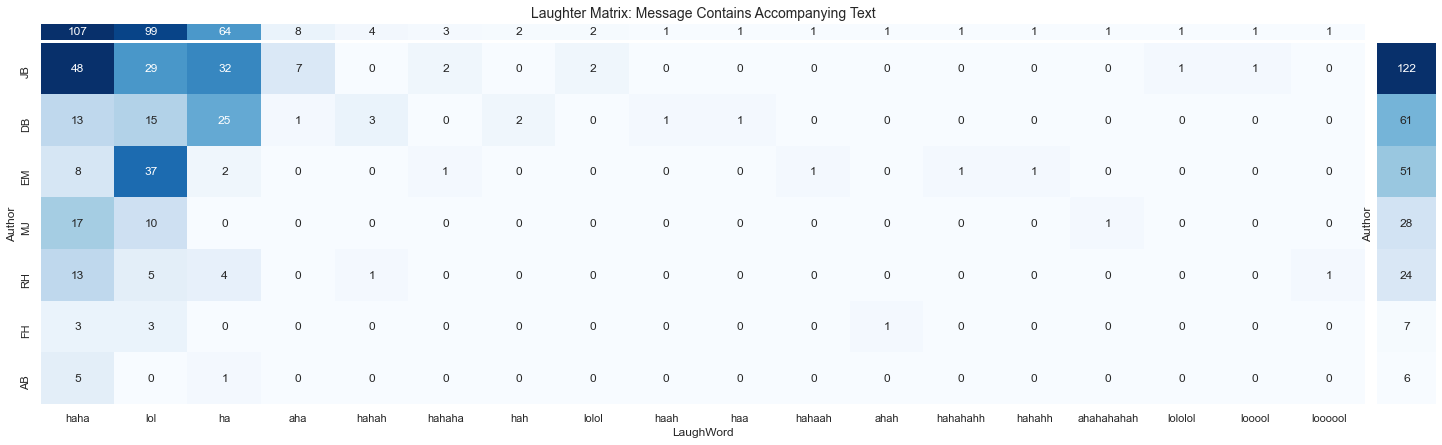

In [12]:
# amended/stripped from https://stackoverflow.com/questions/33379261/how-can-i-have-a-bar-next-to-python-seaborn-heatmap-which-shows-the-summation-of
# create heatmap with totals
fig = plt.figure(figsize=(25,7))
ax2 = plt.subplot2grid((20,20), (0,0), colspan=19, rowspan=1)
ax1 = plt.subplot2grid((20,20), (1,0), colspan=19, rowspan=19)
ax3 = plt.subplot2grid((20,20), (1,19), colspan=1, rowspan=19)

# create grid with rows and cols sorted (condenses colour in top left)
df_lm = pd.pivot_table(df[df.ContainsLaughWord & ~df.OnlyLaughWord][['Author', 'LaughWord', 'Message']]
                       .groupby(['Author', 'LaughWord']).count(),
                       columns='LaughWord',
                       index='Author',
                       values='Message').fillna(0)
df_lm = df_lm.loc[df_lm.sum(axis=1).sort_values(ascending=False).index][df_lm.sum().sort_values(ascending=False).index]

# plot the heatmap
sns.heatmap(df_lm,
            ax=ax1,
            cmap='Blues',
            annot=True,
            cbar=False,
            fmt=',.0f');
# plot the row totals on the far right
sns.heatmap(pd.DataFrame(df_lm.sum(axis=1)), ax=ax3,  annot=True, cmap="Blues", fmt=',.0f', cbar=False, xticklabels=False, yticklabels=False);
# plot the col totals on top with an accompanying title
sns.heatmap((pd.DataFrame(df_lm.sum(axis=0))).transpose(), ax=ax2,  annot=True, cmap="Blues", fmt=',.0f', cbar=False, xticklabels=False, yticklabels=False);
ax2.set_title('Laughter Matrix: Message Contains Accompanying Text', fontdict={'fontsize': 14});

Takeaways:
 - A much higher concentration of laugh responses, __with notably 'ha' entering the mix when dormant as a single word response__
 - JB surges to the top here - __he appreciates the banter, but he doth then respond as well__
 - 'lol' and 'haha' both vie for the coveted top spot, with the use of 'lol' in its ironic form _potentially_ bringing it to the fore

__All in this means that JB reigns supreme for providing those laughter responses.__ But we already know him as the top messenger. The real question becomes, who is providing the real bang for their character-constrained buck? Who, as a % of all their messages, is doling out those haha-y responses?

#### 3biv. All messages containing a laugh word, normalised by total message count

As it doesn't skew the picture, we've focussed here on only the top 5 laugh words.

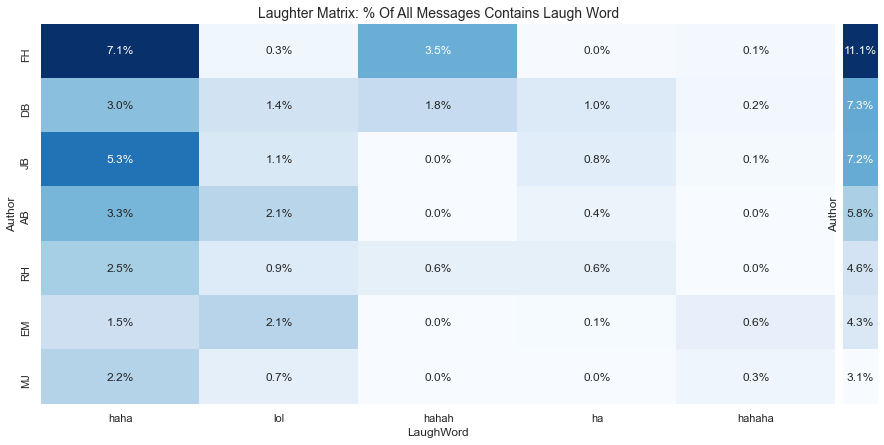

In [13]:
# amended/stripped from https://stackoverflow.com/questions/33379261/how-can-i-have-a-bar-next-to-python-seaborn-heatmap-which-shows-the-summation-of
# create heatmap with totals
fig = plt.figure(figsize=(15,7))
ax1 = plt.subplot2grid((20,20), (0,0), colspan=19, rowspan=20)
ax2 = plt.subplot2grid((20,20), (0,19), colspan=1, rowspan=20)

# create grid with rows and cols sorted (condenses colour in top left)
df_lmp = pd.pivot_table(df[df.ContainsLaughWord][['Author', 'LaughWord', 'Message']]
                       .groupby(['Author', 'LaughWord']).count() / 
                        df[['Author', 'Message']]
                       .groupby(['Author']).count(),
                       columns='LaughWord',
                       index='Author',
                       values='Message').fillna(0)
df_lmp = df_lmp.loc[df_lmp.sum(axis=1).sort_values(ascending=False).index][df_lmp.sum().sort_values(ascending=False).head(5).index]

# plot the heatmap
sns.heatmap(df_lmp,
            ax=ax1,
            cmap='Blues',
            annot=True,
            cbar=False,
            fmt='.1%');
ax1.set_title('Laughter Matrix: % Of All Messages Contains Laugh Word', fontdict={'fontsize': 14});
# plot the row totals on the far right
sns.heatmap(pd.DataFrame(df_lmp.sum(axis=1)), ax=ax2,  annot=True, cmap="Blues", fmt='.1%', cbar=False, xticklabels=False, yticklabels=False);

Given JB's consistent overall contribution, once _normalising the laughs_ he doles out by the his overall message count, this brings him back to the middle of the table. FH's relative overall lack of activity gives him a considerable lead at the top. __And even more so than before, I remain a miserable bastard bringing up the rear.__

-----

## Step 4: Answer The Question - Are We Havin' A Laugh?

Having gotten a bit carried away, it's time to check up on the hypothesis that got us goin. Time to check the trend - once we account for the overall number of messages - are we doling out more haha's and the likes now?

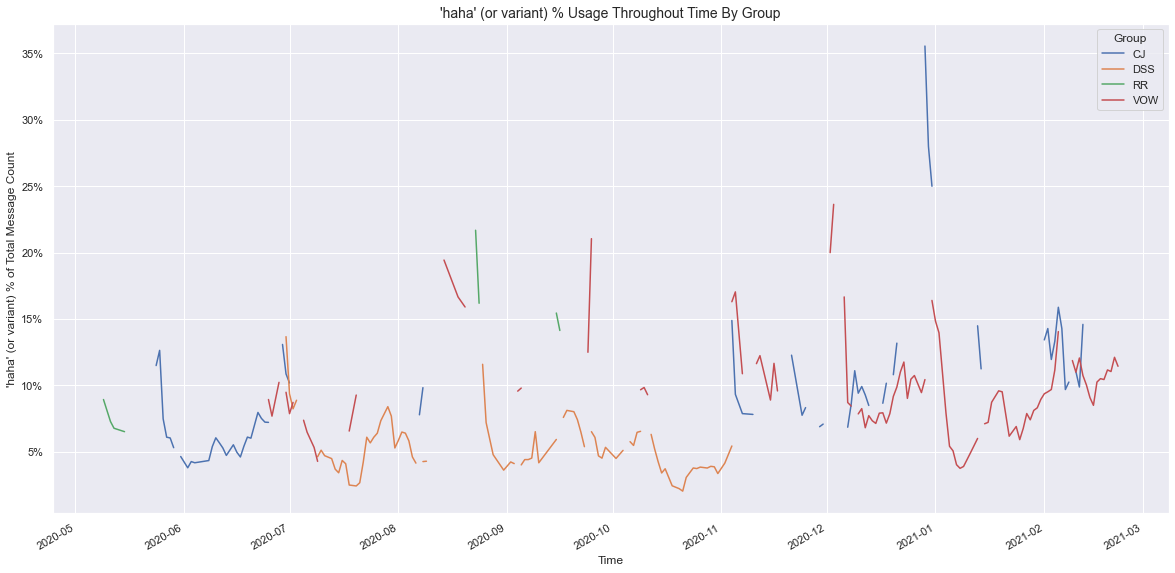

In [14]:
fig, ax = plt.subplots(figsize=(20,10));
pd.pivot_table((df[df.OnlyLaughWord][['Date', 'Group', 'Message']]
              .groupby(['Group', 'Date']).count().fillna(0).rolling(7).mean() /
              df[['Date', 'Group', 'Message']]
              .groupby(['Group', 'Date']).count().fillna(0).rolling(7).mean()),
               columns='Group',
               index='Date',
               values='Message').plot(ax=ax)

ax.set_title("'haha' (or variant) % Usage Throughout Time By Group", fontdict={'fontsize': 14});
ax.set_xlabel('Time')
ax.set_ylabel("'haha' (or variant) % of Total Message Count")
ax.set_yticklabels(['{:,}'.format(int(x*100))+'%' for x in ax.get_yticks().tolist()]);

The data sure is patchy and volatile (percentages oft more volatile than the underlying series) _but_:
 - __laughter is on the rise, buy while you still can!!!__: VOW has just surged through 10% of messages being a sole laughter response
 - something effin' funny went down on the group CJ at the end of the year

Let's look at the overall picture - non-message volume normalised - to help paint that serotonin-inducing picture.

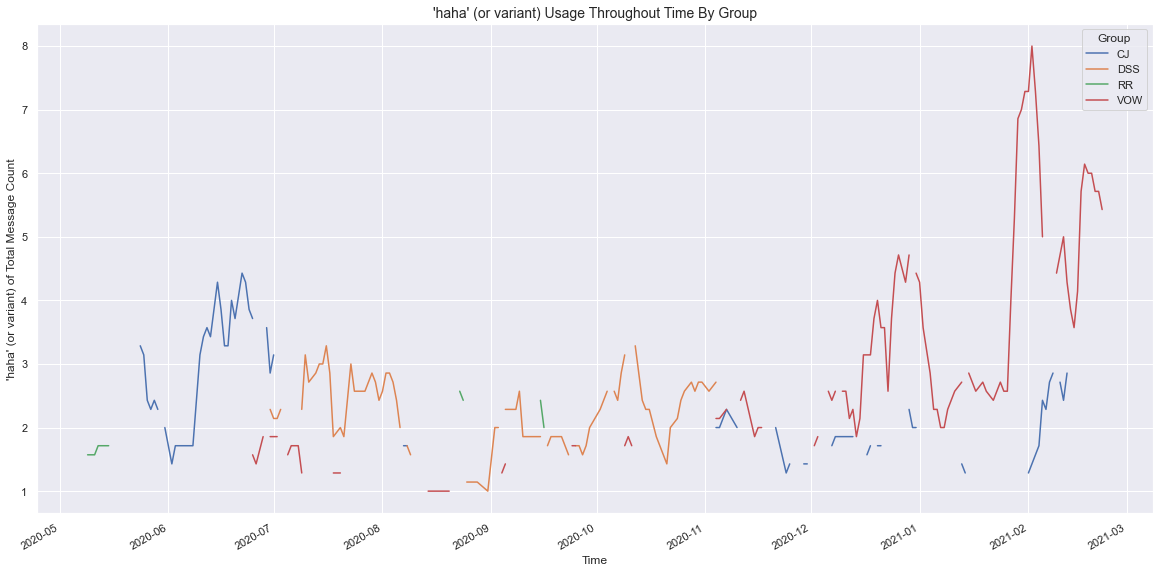

In [15]:
fig, ax = plt.subplots(figsize=(20,10));
pd.pivot_table(df[df.OnlyLaughWord][['Date', 'Group', 'Message']]
              .groupby(['Group', 'Date']).count().fillna(0).rolling(7).mean(),
               columns='Group',
               index='Date',
               values='Message').plot(ax=ax)

ax.set_title("'haha' (or variant) Usage Throughout Time By Group", fontdict={'fontsize': 14});
ax.set_xlabel('Time')
ax.set_ylabel("'haha' (or variant) of Total Message Count");

Contrasting to the overall message trends in 2a. (wave-like, similar to corona), __laughter has certainly increased in the last few months. Long may it continue.__ But _who_ is driving this rise in laughter-only filled responses? Let's dive in and look at the individual performances:

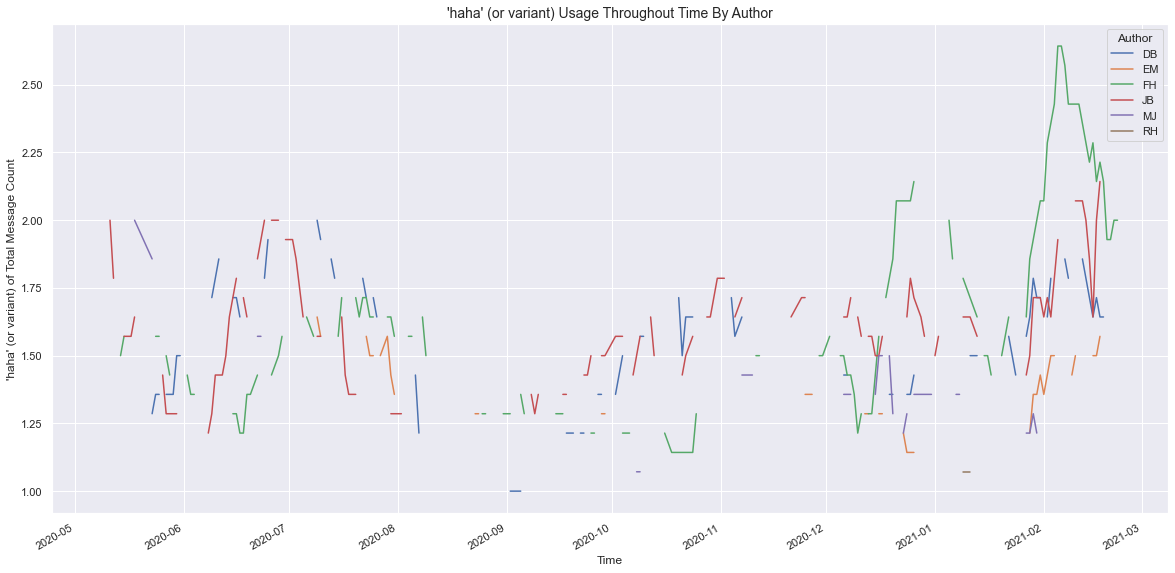

In [16]:
fig, ax = plt.subplots(figsize=(20,10));
pd.pivot_table(df[df.OnlyLaughWord][['Date', 'Author', 'Message']]
              .groupby(['Author', 'Date']).count().fillna(0).rolling(14).mean(),
               columns='Author',
               index='Date',
               values='Message').plot(ax=ax)

ax.set_title("'haha' (or variant) Usage Throughout Time By Author", fontdict={'fontsize': 14});
ax.set_xlabel('Time')
ax.set_ylabel("'haha' (or variant) of Total Message Count");

__We all are!!!__ FH experiences extreme volatility, but on the whole we are all doing our bit to make our group chats more vibey.

Finally, let's have a look at the monthly performance of our top 5 laugh words - can any variant look to challenge 'haha' for the top spot?

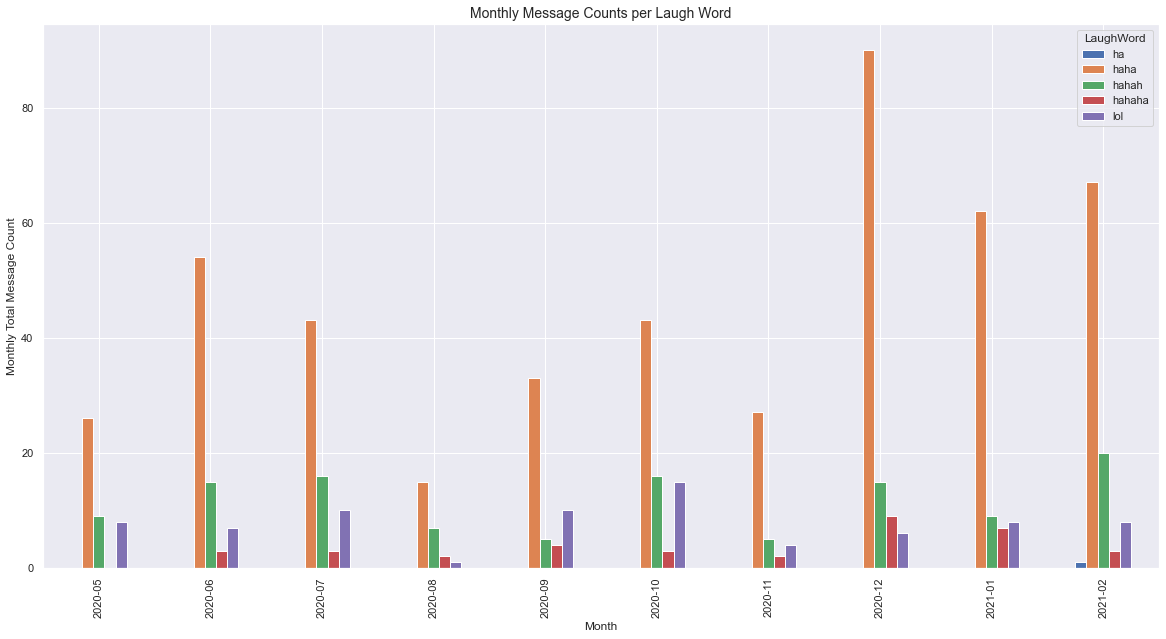

In [17]:
top_laugh_words = df[df.ContainsLaughWord][['LaughWord', 'Message']].groupby(['LaughWord']).count().sort_values('Message', ascending=False).head().index.values

fig, ax = plt.subplots(figsize=(20,10))
pd.pivot_table(df[(df.OnlyLaughWord) & (df.LaughWord.isin(top_laugh_words))][['Message', 'Month', 'LaughWord']]
               .groupby(['Month', 'LaughWord']).count(),
               columns='LaughWord',
               index='Month',
               values='Message').plot(kind='bar', ax=ax)
ax.set_title('Monthly Message Counts per Laugh Word', fontdict={'fontsize': 14})
ax.set_xlabel('Month')
ax.set_ylabel('Monthly Total Message Count');

Simply put, no. 'haha' reigns supreme with the best 'hahah' can hope for a nomination for best 2021 Newcomer, however it's still a long way off reaching the lofty heights of 60 occurrences per month (unless we collectively become a bit funnier).

----

## Step 5. Make Some Insightful Concluding Remark

__So, it appears our hypothesis _cannot_ be rejected and we do indeed seem to be being more generous with our laughter!!__ What a nice bunch of guys we must be becoming. However, 'haha' and its variants are not necessarily the sole indicator of a good time. There is no 'haha' without some content to generate it - __an idea to thoroughly over-analyse in another rambling essay.__

In [19]:
# df.to_csv('../data/wa_df.csv', index=False)